In [1]:
import pandas as pd
import numpy as np

import mne
from mne.time_frequency import psd_welch

import helper as helper #custom

# visualization stuff
%matplotlib inline 
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import seaborn as sns

# 1. Import Data

In [2]:
df = pd.read_csv('data/ssvep-10trials-3s-chaky-bigsquare.csv')

In [3]:
df.shape #check the size of 0

(32952, 10)

In [4]:
print(df[df.Marker==3].shape) #15hz
print(df[df.Marker==2].shape) #10hz
print(df[df.Marker==1].shape) #6hz

(10, 10)
(10, 10)
(10, 10)


df.rename(columns={'Unnamed: 1':'Fp1',
                          'Unnamed: 2':'Fp2',
                          'Unnamed: 3':'F3',
                          'Unnamed: 4':'F4'}, 
                 inplace=True)

In [5]:
df.rename(columns={'Unnamed: 1':'O1',
                          'Unnamed: 2':'Oz',
                          'Unnamed: 3':'O2'
                      }, 
                 inplace=True)

In [6]:
df.head()

,timestamps,O1,Oz,O2,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Marker
0,24727.394,58600.641,53608.289,49404.219,187500.0,-187500.016,-187500.016,-187500.016,-187500.016,0
1,24727.394,58582.133,53588.531,49381.977,187500.0,-187500.016,-187500.016,-187500.016,-187500.016,0
2,24727.395,58619.953,53622.977,49414.520,187500.0,-187500.016,-187500.016,-187500.016,-187500.016,0
3,24727.395,58660.992,53663.207,49452.832,187500.0,-187500.016,-187500.016,-187500.016,-187500.016,0
4,24727.395,58645.566,53651.676,49443.469,187500.0,-187500.016,-187500.016,-187500.016,-187500.016,0


In [7]:
df = df.drop(["timestamps", "Unnamed: 4", "Unnamed: 5", "Unnamed: 6", "Unnamed: 7", "Unnamed: 8"], axis=1)

df = df.drop(["timestamps"], axis=1)

In [8]:
df.head()

,O1,Oz,O2,Marker
0,58600.641,53608.289,49404.219,0
1,58582.133,53588.531,49381.977,0
2,58619.953,53622.977,49414.520,0
3,58660.992,53663.207,49452.832,0
4,58645.566,53651.676,49443.469,0


# 2. Transform Data into Raw MNE object

Creating RawArray with float64 data, n_channels=4, n_times=32952
    Range : 0 ... 32951 =      0.000 ...   131.804 secs
Ready.
Effective window size : 8.192 (s)


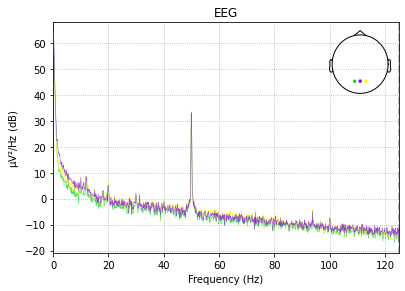

In [9]:
raw = helper.df_to_raw(df)

# 3. Preprocessing

## Notch Filter

Some artifacts are restricted to certain frequencies and can therefore be fixed by filtering. An artifact that typically affects only some frequencies is due to the power line.

Power-line noise is a noise created by the electrical network. It is composed of sharp peaks at 50Hz (or 60Hz depending on your geographical location). Some peaks may also be present at the harmonic frequencies, i.e. the integer multiples of the power-line frequency, e.g. 100Hz, 150Hz, … (or 120Hz, 180Hz, …).

Remove the 50Hz power line noise in Thailand.  We will also be remove its harmonics, i.e., 100Hz, 150Hz, etc.  Since our signal is 125Hz (250Hz / 2 according to Nyquist Theorem), we shall run the harmonics until 125 Hz.

In [10]:
raw.notch_filter(np.arange(50, 125, 50), filter_length='auto', phase='zero') #250/2 based on Nyquist Theorem

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)



<RawArray | 4 x 32952 (131.8 s), ~1.0 MB, data loaded>

Effective window size : 8.192 (s)


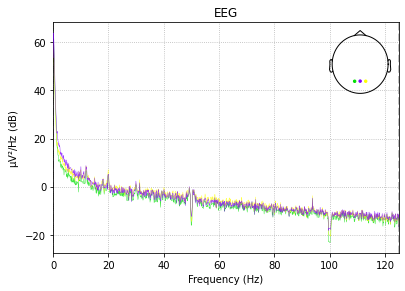

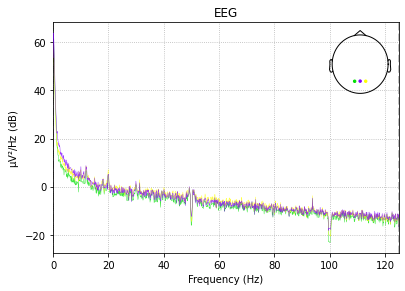

In [11]:
#observe that the 50Hz noise is now gone, yay!
raw.plot_psd()

## Band pass filter

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 20.00 Hz: -6.02, -6.02 dB

Effective window size : 8.192 (s)


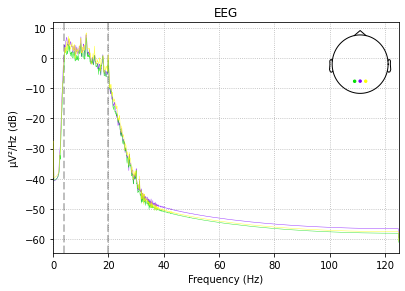

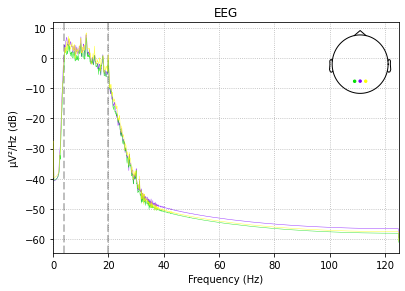

In [12]:
#Filter code looks like this
raw.filter(4,20, method='iir')
raw.plot_psd()

## Independent component analysis

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 sec)

Effective window size : 8.192 (s)


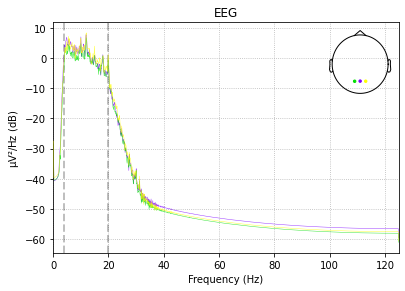

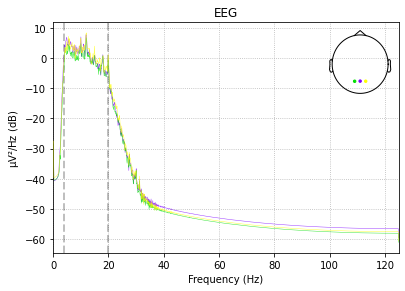

In [13]:
#filtering to remove slow drifts; also make copy of raw for later signal reconstruction
from mne.preprocessing import ICA

filt_raw = raw.copy()
filt_raw.load_data().filter(l_freq=1., h_freq=None)
filt_raw.plot_psd()

In [14]:
# set up and fit the ICA
ica = ICA(n_components=3, random_state=32)
ica.fit(filt_raw)

Fitting ICA to data using 3 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selecting by number: 3 components
Fitting ICA took 0.2s.


<ICA  |  raw data decomposition, fit (fastica): 32952 samples, 3 components, channels used: "eeg">

In [ ]:
ica.plot_sources(filt_raw)
ica.plot_components()

In [ ]:
#test excluding 0 component
ica.plot_overlay(filt_raw, exclude=[0], picks='eeg')

In [ ]:
ica.exclude = [] #we want to cut down the 0, 1 component, then apply(self) to reconstruct the signal

In [ ]:
# ica.apply() changes the Raw object in-place, so let's make a copy first for comparison:
orig_raw = raw.copy()  #we apply ica to raw
ica.apply(raw)

regexp = r'(O)'
artifact_picks = mne.pick_channels_regexp(raw.ch_names, regexp=regexp)

orig_raw.plot(order=artifact_picks, n_channels=len(artifact_picks))
raw.plot(order=artifact_picks, n_channels=len(artifact_picks), start=1)

# 3. Epoching

In [ ]:
#this one requires expertise to specify the right tmin, tmax
event_id = {'6Hz': 1, '10Hz' : 2, '15Hz' : 3}
epochs = helper.getEpochs(raw, event_id, tmin=-0.5, tmax=3)

## Stimuli-Specific PSD

In [ ]:
fig = plt.figure(figsize=(10, 4))

axes = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # left, bottom, width, height (range 0 to 1)

psd1, freq1 = psd_welch(epochs['6Hz'], n_fft=1028, n_per_seg=256 * 3)
psd2, freq2 = psd_welch(epochs['10Hz'], n_fft=1028, n_per_seg=256 * 3)
psd3, freq3 = psd_welch(epochs['15Hz'], n_fft=1028, n_per_seg=256 * 3)

logpsd1 = 10 * np.log10(psd1)
logpsd2 = 10 * np.log10(psd2)
logpsd3 = 10 * np.log10(psd3)

log_psd1_mean = logpsd1.mean(0)
log_psd1_std = logpsd1.mean(0)

log_psd2_mean = logpsd2.mean(0)
log_psd2_std = logpsd2.mean(0)

log_psd3_mean = logpsd3.mean(0)
log_psd3_std = logpsd3.mean(0)

axes.plot(freq1, log_psd1_mean[[0], :].mean(0), color='b', label='6Hz')
axes.plot(freq2, log_psd2_mean[[0], :].mean(0), color='r', label='10Hz')
axes.plot(freq2, log_psd3_mean[[0], :].mean(0), color='g', label='15Hz')

axes.set_title('')
axes.set_ylabel('Power Spectral Density (dB)')
axes.set_xlim(4, 40)
axes.set_ylim(-170, -100)
axes.legend()

# Decoding

In [ ]:
import filterbankcspDecoding as fcsp #custom

fcsp.decode(epochs)